# Solve Partial Differential Equation with Physics-Informed Neural Operator(PINO)

본 예제에서는 Physic-Informed Neural Operator(PINO)를 통해 Burger's Equation의 해를 계산하도록 훈련시키는 방법을 보여줍니다. 해당 코드는 "Physics-Informed Neural Operator for Learning Partial Differential Equations"의 Section 4.1의 예제 코드를 바탕으로 구성되었습니다. 추후 다른 예제 코드가 궁금하실 경우 본문 하단에 논문과 예제 코드의 참조 링크가 있으니, 참조 부탁 드립니다.

 Burger's equation을 다양한 응용 수학에서 사용되는 편미분 방정식으로, 유체역학, 비선형 음향학, 기체 동역학 등 다양한 분야에서 사용됩니다. 해당 방정식의 구성은 아래와 같습니다.

$$∂_tu(x, t) + ∂_x(u^2(x, t)/2) = ν∂_{xx} u(x, t),\quad x ∈ (0, 1), t ∈ (0, 1]$$
$$u(x, 0) = u_0(x), \quad x ∈ (0, 1)$$

위의 방정식은 $u_0 ∈ L^2_{per}((0, 1); R)$의 주기적 경계 조건을 가지고 있습니다. $ν$는 점도 계수로 해당 예제에서는 0.01의 수치가 사용됩니다. 본 예제 코드는 초기 조건을 솔루션 $G_†: u_0 → u|_{[0,1]}.$에 매핑하는 연산자를 학습하는 것을 목표로 합니다.






## Contact Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/My Drive/PINO/physics_informed-master"

/content/drive/My Drive/PINO/physics_informed-master


In [ ]:
#from argparse import ArgumentParser
import argparse
import yaml
import torch
#from models import FNO2d
from train_utils import Adam
#from train_utils.datasets import BurgersLoader
#from train_utils.train_2d import train_2d_burger
#from train_utils.eval_2d import eval_burgers
import scipy.io
import numpy as np

## Generating Data

신경 연산자를 훈련시키기 위해 훈련 데이터를 불러올 Matlab 데이터 파일을 불러올 수 있는 클래스를 정의합니다.

\
기본적으로 MatReader는 추후 본격적으로 데이터를 불러오게 될 BurgersLoader에서 쓰일 함수들을 정의해 줍니다. 이 때 불러올 데이터의 형식을 지정할 수도 있으며, GPU 사용 여부 또한 결정할 수 있습니다.

In [ ]:
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        self.data = scipy.io.loadmat(self.file_path)
        self.old_mat = True

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

위에서 정의한 MatReader를 통해 기존에 생성한 훈련 데이터에서부터 필요한 데이터를 추출합니다. 생성자 "__init__"이 input으로 받는 매개변수들의 의미는 다음과 같습니다.

\
datapath : Matlab data가 위치해있는 경로
\
nx : 공간 그리드의 총 포인트 수
\
nt : 시간 그리드 총 포인트 수
\
sub : 공간 단위의 하위 샘플링 비율
\
sub_t : 시간 단위의 하위 샘플링 비율

In [ ]:
class BurgersLoader(object):
    def __init__(self, datapath, nx=2 ** 10, nt=100, sub=8, sub_t=1, new=False):
        dataloader = MatReader(datapath)
        self.sub = sub
        self.sub_t = sub_t
        self.s = nx // sub
        self.T = nt // sub_t
        self.new = new
        if new:
            self.T += 1
        self.x_data = dataloader.read_field('input')[:, ::sub]
        self.y_data = dataloader.read_field('output')[:, ::sub_t, ::sub]
        self.v = dataloader.read_field('visc').item()

또한 dataloader를 생성하는 make_loader가 Input으로 받는 매개변수의 의미는 다음과 같습니다.

\
n_sample : 한번에 사용할 샘플의 개수
\
batch_size : Dataloader에서 배치의 크기
\
start : Load를 시작할 위치를 지정하기 위한 인덱스

해당 코드에서는 각각 한번의 step에서 사용할 공간과 시간에 대한 그리드를 지정해 준뒤, Xs(Input Data)와 차원을 같은 차원으로 맞추어 줍니다. 최종적으로 Xs 데이터와 그리드들을 하나로 결합해 준뒤 ys(Output Data)와의 Dataset을 생성하여 Dataloader를 만들어 줍니다.

In [ ]:
    def make_loader(self, n_sample, batch_size, start=0, train=True):
            Xs = self.x_data[start:start + n_sample]
            ys = self.y_data[start:start + n_sample]

            if self.new:
                gridx = torch.tensor(np.linspace(0, 1, self.s + 1)[:-1], dtype=torch.float)
                gridt = torch.tensor(np.linspace(0, 1, self.T), dtype=torch.float)
            else:
                gridx = torch.tensor(np.linspace(0, 1, self.s), dtype=torch.float)
                gridt = torch.tensor(np.linspace(0, 1, self.T + 1)[1:], dtype=torch.float)
            gridx = gridx.reshape(1, 1, self.s)
            gridt = gridt.reshape(1, self.T, 1)

            Xs = Xs.reshape(n_sample, 1, self.s).repeat([1, self.T, 1])
            Xs = torch.stack([Xs, gridx.repeat([n_sample, self.T, 1]), gridt.repeat([n_sample, 1, self.s])], dim=3)
            dataset = torch.utils.data.TensorDataset(Xs, ys)
            if train:
                loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            else:
                loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
            return loader

## Fourier Neural Operator(FNO)

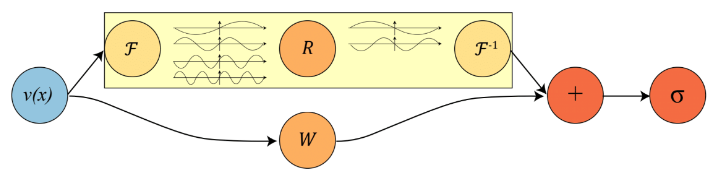

Fourier layer의 단계를 간단하게 3단계로 나누면 다음과 같습니다.


1. Fourier transform $\mathcal{F}$
2. Linear transform on the lower Fourier modes $\mathcal{R}$
3. Inverse Fourier transform $\mathcal{F^{-1}}$

위의 세 단계를 거친후 bias term W를 적용시킨 후 activate function을 적용시켜줍니다.

\
이와 같이 Fourier Layer에서는 mode가 중요한 역할을 합니다. 아래 코드에서도 mode1, mode2를 인수로 받는 모습을 확인할 수 있는데, 이는 각각 첫번째 차원과 두번째 차원에서 사용할 Fourier mode의 개수를 나타내는 인자입니다. 해당 변수들은 Fourier Transform을 수행할 때, 입력 데이터의 주파수 성분들을 나타내는 일종의 기저함수의 역할을 합니다.

\
또한 아래의 코드에서 sp_convs(SpectralConv2d), ws(Conv1d)가 정의된 모습을 확인할 수 있습니다.

\
SpectralConv2d Layer의 경우 Fourier Transform을 수행하는 Layer로 Fourier Layer의 3단계(그림의 노란 박스) 부분을 수행합니다. 이를 통해 입력 데이터의 공간적 특성과 주파수적 특성을 동시에 학습할 수 있게 됩니다.

\
Conv1d Layer는 1차원 Convolution 연산을 수행하여 위 그림의 Weight Term을 얻을 수 있도록 합니다.

In [ ]:
import torch.nn as nn
#from models.basics import SpectralConv2d
from models.utils import _get_act, add_padding2, remove_padding2


class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,
                 width=64, fc_dim=128,
                 layers=None,
                 in_dim=3, out_dim=1,
                 act='gelu',
                 pad_ratio=[0., 0.]):
        super(FNO2d, self).__init__()
        """
        Args:
            - modes1: list of int, number of modes in first dimension in each layer
            - modes2: list of int, number of modes in second dimension in each layer
            - width: int, optional, if layers is None, it will be initialized as [width] * [len(modes1) + 1]
            - in_dim: number of input channels
            - out_dim: number of output channels
            - act: activation function, {tanh, gelu, relu, leaky_relu}, default: gelu
            - pad_ratio: list of float, or float; portion of domain to be extended. If float, paddings are added to the right.
            If list, paddings are added to both sides. pad_ratio[0] pads left, pad_ratio[1] pads right.
        """
        if isinstance(pad_ratio, float):
            pad_ratio = [pad_ratio, pad_ratio]
        else:
            assert len(pad_ratio) == 2, 'Cannot add padding in more than 2 directions'
        self.modes1 = modes1
        self.modes2 = modes2

        self.pad_ratio = pad_ratio
        # input channel is 3: (a(x, y), x, y)
        if layers is None:
            self.layers = [width] * (len(modes1) + 1)
        else:
            self.layers = layers
        self.fc0 = nn.Linear(in_dim, layers[0])

        self.sp_convs = nn.ModuleList([SpectralConv2d(
            in_size, out_size, mode1_num, mode2_num)
            for in_size, out_size, mode1_num, mode2_num
            in zip(self.layers, self.layers[1:], self.modes1, self.modes2)])

        self.ws = nn.ModuleList([nn.Conv1d(in_size, out_size, 1)
                                 for in_size, out_size in zip(self.layers, self.layers[1:])])

        self.fc1 = nn.Linear(layers[-1], fc_dim)
        self.fc2 = nn.Linear(fc_dim, layers[-1])
        self.fc3 = nn.Linear(layers[-1], out_dim)
        self.act = _get_act(act)

FNO가 적용되는 과정입니다.

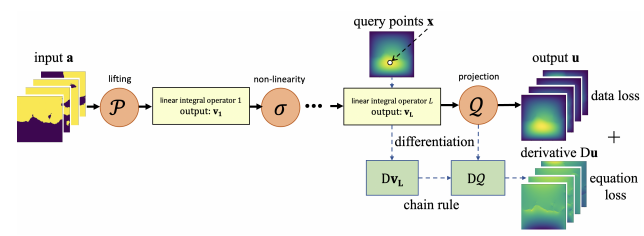

In [ ]:
    def forward(self, x):
        '''
        Args:
            - x : (batch size, x_grid, y_grid, 2)
        Returns:
            - x: (batch size, x_grid, y_grid, 1)
        '''
        size_1, size_2 = x.shape[1], x.shape[2]
        if max(self.pad_ratio) > 0:
            num_pad1 = [round(i * size_1) for i in self.pad_ratio]
            num_pad2 = [round(i * size_2) for i in self.pad_ratio]
        else:
            num_pad1 = num_pad2 = [0.]

        length = len(self.ws)
        batchsize = x.shape[0]

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)   # B, C, X, Y

        x = add_padding2(x, num_pad1, num_pad2)
        size_x, size_y = x.shape[-2], x.shape[-1]

        for i, (speconv, w) in enumerate(zip(self.sp_convs, self.ws)):
            x1 = speconv(x)
            x2 = w(x.view(batchsize, self.layers[i], -1)).view(batchsize, self.layers[i+1], size_x, size_y)
            x = x1 + x2
            if i != length - 1:
                x = self.act(x)

        x = remove_padding2(x, num_pad1, num_pad2)
        x = x.permute(0, 2, 3, 1)  # B, X, Y, C

        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        return x

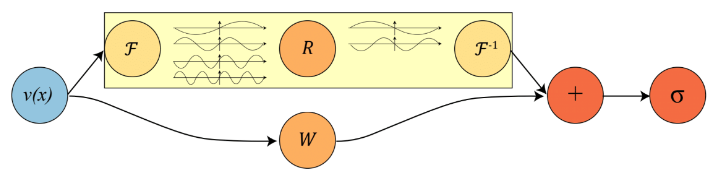

1. Fourier transform $\mathcal{F}$
2. Linear transform on the lower Fourier modes $\mathcal{R}$
3. Inverse Fourier transform $\mathcal{F^{-1}}$

In [ ]:
################################################################
# 2d fourier layer
################################################################


def compl_mul2d(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
    res =  torch.einsum("bixy,ioxy->boxy", a, b)
    return res

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def forward(self, x):
        batchsize = x.shape[0]
        size1 = x.shape[-2]
        size2 = x.shape[-1]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[2, 3])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, device=x.device,
                                dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-2), x.size(-1)), dim=[2, 3])
        return x

## Defined Loss function

Operator $G_{\theta}$는 $\mathcal{L}_{pde}$와 $\mathcal{L}_{op}$의 합으로 인한 손실함수를 통해 훈련이 됩니다.

\
이 때 $\mathcal{L}_{op}$는 다음과 같습니다.
$$\mathcal{L}_{op}(G_{\theta_i}(a),G_{\theta_o}(a)) := \Vert G_{\theta_i}(a)-G_{\theta_o}(a)\Vert^2_u$$

In [ ]:
import torch.nn.functional as F

class LpLoss(object):
    '''
    loss function with rel/abs Lp loss
    '''
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

$\mathcal{L}_{pde}$를 계산하기 위해 유한차분법(Finite Difference Method)를 통해 Burger's Equation을 계산합니다. 유한차분법을 통해 Burger's Equation을 해석하는 비슷한 예제를 본문 하단에 첨부하였으니 관심 있으신 분은 확인해 주시면 감사하겠습니다.

\
Du는 Burger's Equation의 좌항에 우항을 뺀 값이기 때문에 PINO가 정확하게 예측을 할 수록 0에 가까워 집니다.

In [ ]:
def FDM_Burgers(u, v, D=1):
    batchsize = u.size(0)
    nt = u.size(1)
    nx = u.size(2)

    u = u.reshape(batchsize, nt, nx)
    dt = D / (nt-1)
    dx = D / (nx)

    u_h = torch.fft.fft(u, dim=2)
    # Wavenumbers in y-direction
    k_max = nx//2
    k_x = torch.cat((torch.arange(start=0, end=k_max, step=1, device=u.device),
                     torch.arange(start=-k_max, end=0, step=1, device=u.device)), 0).reshape(1,1,nx)
    ux_h = 2j *np.pi*k_x*u_h
    uxx_h = 2j *np.pi*k_x*ux_h
    ux = torch.fft.irfft(ux_h[:, :, :k_max+1], dim=2, n=nx)
    uxx = torch.fft.irfft(uxx_h[:, :, :k_max+1], dim=2, n=nx)
    ut = (u[:, 2:, :] - u[:, :-2, :]) / (2 * dt)
    Du = ut + (ux*u - v*uxx)[:,1:-1,:]
    return Du

$\mathcal{L}_{pde}$은 $\mathcal{L}_{ic}$와 $\mathcal{L}_{physics}$의 항으로 구성이 됩니다.

\
이 때 loss_u가 $\mathcal{L}_{ic}$이며, loss_f가 $\mathcal{L}_{physics}$입니다.

In [ ]:
def PINO_loss(u, u0, v):
    batchsize = u.size(0)
    nt = u.size(1)
    nx = u.size(2)

    u = u.reshape(batchsize, nt, nx)
    # lploss = LpLoss(size_average=True)

    index_t = torch.zeros(nx,).long()
    index_x = torch.tensor(range(nx)).long()
    boundary_u = u[:, index_t, index_x]
    loss_u = F.mse_loss(boundary_u, u0)

    Du = FDM_Burgers(u, v)[:, :, :]
    f = torch.zeros(Du.shape, device=u.device)
    loss_f = F.mse_loss(Du, f)

    # loss_bc0 = F.mse_loss(u[:, :, 0], u[:, :, -1])
    # loss_bc1 = F.mse_loss((u[:, :, 1] - u[:, :, -1]) /
    #                       (2/(nx)), (u[:, :, 0] - u[:, :, -2])/(2/(nx)))
    return loss_u, loss_f

## Train Neural Operator

모델을 훈련시키기 위한 train_2d_burger 함수를 정의합니다.
\
아래 코드는 훈련을 하기 전 옵션에 대해 정의 합니다.
wandb는 모델의 훈련 과정에서 로그 등의 다양한 정보를 시각화하고 기록하는데 쓰이는 라이브러리로 본 코드에서는 로그를 기록하는데 쓰입니다.

In [ ]:
from train_utils.utils import save_checkpoint
from tqdm import tqdm
try:
    import wandb
except ImportError:
    wandb = None

def train_2d_burger(model,
                    train_loader, v,
                    optimizer, scheduler,
                    config,
                    rank=0, log=False,
                    project='PINO-2d-default',
                    group='default',
                    tags=['default'],
                    use_tqdm=True):
    if rank == 0 and wandb and log:
        run = wandb.init(project=project,
                         entity=config['log']['entity'],
                         group=group,
                         config=config,
                         tags=tags, reinit=True,
                         settings=wandb.Settings(start_method="fork"))

    data_weight = config['train']['xy_loss']
    f_weight = config['train']['f_loss']
    ic_weight = config['train']['ic_loss']
    model.train()
    myloss = LpLoss(size_average=True)
    pbar = range(config['train']['epochs'])
    if use_tqdm:
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

In [ ]:
    for e in pbar:
        model.train()
        train_pino = 0.0
        data_l2 = 0.0
        train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(rank), y.to(rank)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)

            loss_u, loss_f = PINO_loss(out, x[:, 0, :, 0], v)
            total_loss = loss_u * ic_weight + loss_f * f_weight + data_loss * data_weight

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            data_l2 += data_loss.item()
            train_pino += loss_f.item()
            train_loss += total_loss.item()
        scheduler.step()
        data_l2 /= len(train_loader)
        train_pino /= len(train_loader)
        train_loss /= len(train_loader)
        if use_tqdm:
            pbar.set_description(
                (
                    f'Epoch {e}, train loss: {train_loss:.5f} '
                    f'train f error: {train_pino:.5f}; '
                    f'data l2 error: {data_l2:.5f}'
                )
            )
        if wandb and log:
            wandb.log(
                {
                    'Train f error': train_pino,
                    'Train L2 error': data_l2,
                    'Train loss': train_loss,
                }
            )

        if e % 100 == 0:
            save_checkpoint(config['train']['save_dir'],
                            config['train']['save_name'].replace('.pt', f'_{e}.pt'),
                            model, optimizer)
    save_checkpoint(config['train']['save_dir'],
                    config['train']['save_name'],
                    model, optimizer)
    print('Done!')

최종적으로 그동안 정의해왔던 함수들을 통해 PINO를 실행시키는 run 함수를 정의해줍니다. 해당 Burger's Equation은 1000개의 initial conditions, width = 64, mode = 15, 500 Epoch의 조건으로 훈련을 시킵니다.

In [ ]:
def run(args, config):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    data_config = config['data']
    dataset = BurgersLoader(data_config['datapath'],
                            nx=data_config['nx'], nt=data_config['nt'],
                            sub=data_config['sub'], sub_t=data_config['sub_t'], new=True)
    train_loader = dataset.make_loader(n_sample=data_config['n_sample'],
                                       batch_size=config['train']['batchsize'],
                                       start=data_config['offset'])

    model = FNO2d(modes1=config['model']['modes1'],
                  modes2=config['model']['modes2'],
                  fc_dim=config['model']['fc_dim'],
                  layers=config['model']['layers'],
                  act=config['model']['act']).to(device)
    # Load from checkpoint
    if 'ckpt' in config['train']:
        ckpt_path = config['train']['ckpt']
        ckpt = torch.load(ckpt_path)
        model.load_state_dict(ckpt['model'])
        print('Weights loaded from %s' % ckpt_path)
    optimizer = Adam(model.parameters(), betas=(0.9, 0.999),
                     lr=config['train']['base_lr'])
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=config['train']['milestones'],
                                                     gamma=config['train']['scheduler_gamma'])
    train_2d_burger(model,
                    train_loader,
                    dataset.v,
                    optimizer,
                    scheduler,
                    config,
                    rank=0,
                    log=args.log,
                    project=config['log']['project'],
                    group=config['log']['group'])


config에 쓰이는 burgers-pretrain.yaml 안에 든 정보입니다.

\
data:\
  name: Burgers\
  datapath: '../data/burgers.mat'\
  total_num: 1000\
  offset: 0\
  n_sample: 800\
  nx: 128\
  nt: 100\
  sub: 1\
  sub_t: 1\
\
model:\
  layers: [16, 24, 24, 32, 32]\
  modes1: [15, 12, 9, 9]\
  modes2: [15, 12, 9, 9]\
  fc_dim: 128\
  act: gelu\
  num_pad: 4\
\
train:\
  batchsize: 20\
  epochs: 500\
  milestones: [150, 300, 450]\
  base_lr: 0.001\
  scheduler_gamma: 0.5\
  ic_loss: 10.0\
  f_loss: 1.0\
  xy_loss: 1.0\
  save_dir: 'burgers-FDM'\
  save_name: 'burgers-pretrain-eqn.pt'\
\
log:\
  project: PINO-burgers-pretrain\
  group: taehyun0712\
  entity: dbsxogus132

\
위와 같이 사전에 훈련에 필요한 정보들을 파일에 기입시켜 둔뒤 아래 코드를 통해 파일 안에 든 정보들을 config에 지정한 후 앞서 있던 것처럼 필요할 때 꺼내쓰도록 합니다.

In [ ]:
if __name__ == '__main__':
    '''
    parser = ArgumentParser(description='Basic paser')
    parser.add_argument('--config_path', type=str, help='Path to the configuration file')
    parser.add_argument('--log', action='store_true', help='Turn on the wandb')
    parser.add_argument('--mode', type=str, help='train or test')
    args = parser.parse_args()
'''
    args = argparse.Namespace(
    config_path= "configs/pretrain/burgers-pretrain.yaml",
    log = 'store_true',
    mode="train"
    )

    config_file = args.config_path
    with open(config_file, 'r') as stream:
        config = yaml.load(stream, yaml.FullLoader)
    if args.mode == 'train':
        run(args, config)
    else:
        test(config)


## Test Neural Operator

훈련이 끝난 후 훈련된 모델을 테스트하기 위한 코드입니다. 이전에 정의한 $\mathcal{L}_{data}$과 $\mathcal{L}_{physics}$를 이용하여 상대 평균 오차와 표준 오차를 출력합니다.

In [ ]:
def eval_burgers(model,
                 dataloader,
                 v,
                 config,
                 device,
                 use_tqdm=True):
    model.eval()
    myloss = LpLoss(size_average=True)
    if use_tqdm:
        pbar = tqdm(dataloader, dynamic_ncols=True, smoothing=0.05)
    else:
        pbar = dataloader

    test_err = []
    f_err = []

    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        out = model(x).reshape(y.shape)
        data_loss = myloss(out, y)

        loss_u, f_loss = PINO_loss(out, x[:, 0, :, 0], v)
        test_err.append(data_loss.item())
        f_err.append(f_loss.item())

    mean_f_err = np.mean(f_err)
    std_f_err = np.std(f_err, ddof=1) / np.sqrt(len(f_err))

    mean_err = np.mean(test_err)
    std_err = np.std(test_err, ddof=1) / np.sqrt(len(test_err))

    print(f'==Averaged relative L2 error mean: {mean_err}, std error: {std_err}==\n'
          f'==Averaged equation error mean: {mean_f_err}, std error: {std_f_err}==')

In [ ]:
def test(config):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    data_config = config['data']
    dataset = BurgersLoader(data_config['datapath'],
                            nx=data_config['nx'], nt=data_config['nt'],
                            sub=data_config['sub'], sub_t=data_config['sub_t'], new=True)
    dataloader = dataset.make_loader(n_sample=data_config['n_sample'],
                                     batch_size=config['test']['batchsize'],
                                     start=data_config['offset'])

    model = FNO2d(modes1=config['model']['modes1'],
                  modes2=config['model']['modes2'],
                  fc_dim=config['model']['fc_dim'],
                  layers=config['model']['layers'],
                  act=config['model']['act']).to(device)
    # Load from checkpoint
    if 'ckpt' in config['test']:
        ckpt_path = config['test']['ckpt']
        ckpt = torch.load(ckpt_path)
        model.load_state_dict(ckpt['model'])
        print('Weights loaded from %s' % ckpt_path)
    eval_burgers(model, dataloader, dataset.v, config, device)

In [ ]:
if __name__ == '__main__':
    '''
    parser = ArgumentParser(description='Basic paser')
    parser.add_argument('--config_path', type=str, help='Path to the configuration file')
    parser.add_argument('--log', action='store_true', help='Turn on the wandb')
    parser.add_argument('--mode', type=str, help='train or test')
    args = parser.parse_args()
'''
    args = argparse.Namespace(
    config_path= "configs/test/burgers.yaml",
    log = 'store_true',
    mode="test"
    )

    config_file = args.config_path
    with open(config_file, 'r') as stream:
        config = yaml.load(stream, yaml.FullLoader)
    if args.mode == 'train':
        run(args, config)
    else:
        test(config)


본 페이지는 대한기계학회 고급인공지능 강습회의 가천대학교 김남중 교수님의 "뉴럴 오퍼레이터를 통한 비지도 학습"을 위해 작성된 페이지입니다. 해당 코드는 강연을 위해 약간의 수정이 있는 코드로 구글 코랩을 통해 돌아갈 수 있게 변경되었으니, github 코드를 통해 실행시킬 경우 코드 및 실행 방법이 약간 다를 수 있습니다. 본 페이지는 "Physics-Informed Neural Operator for Learning Partial Differential Equations"를 바탕으로 작성되었습니다.
\
논문 링크 : https://doi.org/10.48550/arXiv.2111.03794
\
Github 링크 : https://github.com/neuraloperator/physics_informed.git
\
유한차분법(FDM) Burger's Equation : https://github.com/nishantsule/Burgers-Equation/blob/master/BurgersEq_1D.ipynb
